## **Importing Independences**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf

from PIL import Image


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings("ignore")

## **Creating a base directory**

In [2]:
# Path dataset asli dan folder untuk data augmentasi
base_dir = 'Food_ingredients_image/Bahan'
augmented_data_dir = 'Food_ingredients_image/augmented_food_ingredients'

## **Image visualization from Dataset**

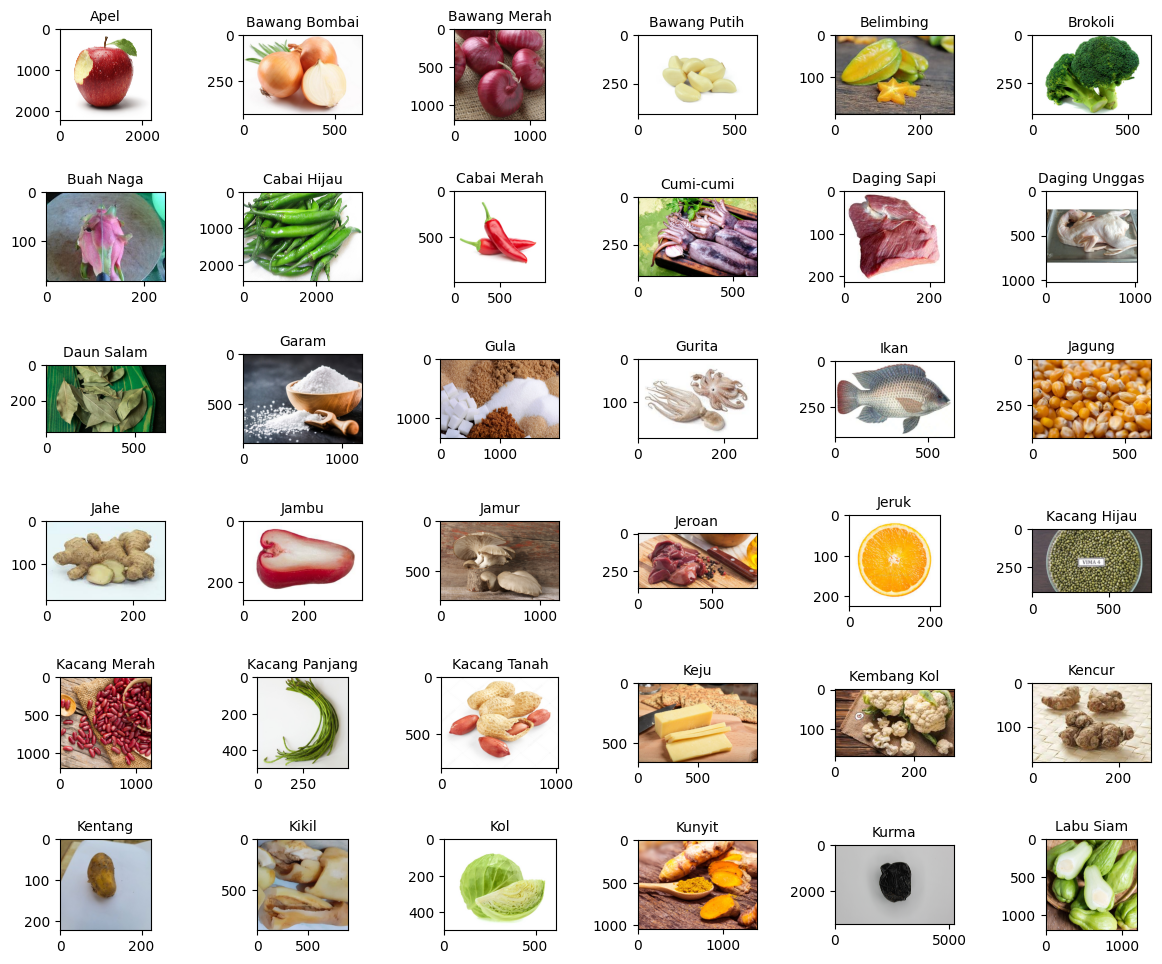

In [3]:
categories = sorted(os.listdir(base_dir))

# Initialize list for sample images
sample_images = []
for category in categories:
    category_path = os.path.join(base_dir, category)
    first_image = os.listdir(category_path)[0]
    sample_images.append(os.path.join(category_path, first_image))

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(12, 10))

for ax, img_path, label in zip(axes.flat, sample_images, categories):
    ax.imshow(plt.imread(img_path))  # Display the image
    ax.set_title(label, fontsize=10)  # title for each image

plt.tight_layout(pad=2)
plt.show()

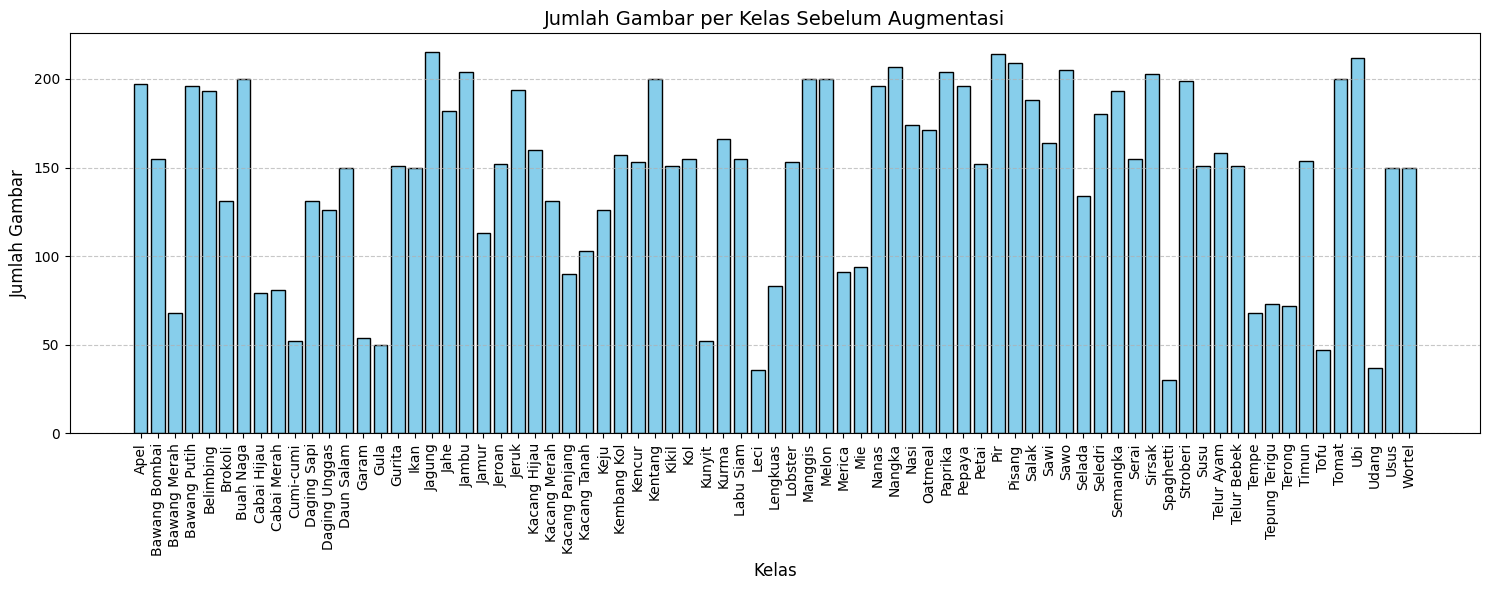

In [4]:

# Hitung jumlah gambar sebelum augmentasi
before_counts = count_images_per_class(base_dir)

# Siapkan data untuk visualisasi
all_classes = sorted(before_counts.keys())
before_values = [before_counts[cls] for cls in all_classes]

# Visualisasi: Grafik batang sebelum augmentasi
plt.figure(figsize=(15, 6))
plt.bar(all_classes, before_values, color='skyblue', edgecolor='black')
plt.title('Jumlah Gambar per Kelas Sebelum Augmentasi', fontsize=14)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Fungsi augmentasi menggunakan TensorFlow
def augment_image(image):
    image = tf.image.resize(image, [224, 224])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_crop(image, size=[224, 224, 3])
    image = tf.clip_by_value(image, 0.0, 255.0)
    return image.numpy().astype(np.uint8)

# Proses augmentasi untuk kelas dengan jumlah gambar < 150
for class_name, count in class_counts.items():
    if count < 150:
        target_class_dir = os.path.join(augmented_data_dir, class_name)
        os.makedirs(target_class_dir, exist_ok=True)
        
        # Salin gambar asli ke folder baru
        original_class_dir = os.path.join(base_dir, class_name)
        for img_name in os.listdir(original_class_dir):
            src_path = os.path.join(original_class_dir, img_name)
            dst_path = os.path.join(target_class_dir, img_name)
            shutil.copy(src_path, dst_path)
        
        # Lakukan augmentasi
        for img_name in os.listdir(original_class_dir):
            img_path = os.path.join(original_class_dir, img_name)
            img = Image.open(img_path).convert('RGB')
            img_array = np.array(img)
            for i in range(max(0, (150 - count) // count + 1)):
                augmented_img = augment_image(img_array)
                augmented_img_pil = Image.fromarray(augmented_img)
                augmented_img_pil.save(os.path.join(target_class_dir, f'aug_{i}_{img_name}'))

# Salin kelas dengan jumlah gambar >= 150 tanpa augmentasi
for class_name, count in class_counts.items():
    if count >= 150:
        src_class_dir = os.path.join(base_dir, class_name)
        dst_class_dir = os.path.join(augmented_data_dir, class_name)
        os.makedirs(dst_class_dir, exist_ok=True)
        for img_name in os.listdir(src_class_dir):
            src_path = os.path.join(src_class_dir, img_name)
            dst_path = os.path.join(dst_class_dir, img_name)
            shutil.copy(src_path, dst_path)

print("Augmentasi selesai. Data disimpan di:", augmented_data_dir)

## **Membagi Dataset Menjadi Train, Test, dan Validation**

In [4]:
# Membuat direktori untuk train, validation, dan test
train_dir = 'Food_ingredients_image/split/train'
val_dir = 'Food_ingredients_image/split/validation'
test_dir = 'Food_ingredients_image/split/test'

## **Pra-Pemrosesan Data Gambar**

In [5]:
# Data augmentation dan normalisasi untuk train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Hanya normalisasi untuk validation dan test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generator data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 9742 images belonging to 75 classes.
Found 1427 images belonging to 75 classes.
Found 2826 images belonging to 75 classes.


## **Pembuatan Model CNN**

In [6]:
# Pre-trained model dengan custom CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(75, activation='softmax')  # 75 kelas
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(75, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

In [5]:
# Pre-trained Model dengan EfficientNetB0
# Muat model pre-trained EfficientNetB0 tanpa lapisan teratas
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Bekukan lapisan pre-trained untuk transfer learning awal
base_model.trainable = False

# Tambahkan lapisan kustom
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(75, activation='softmax')(x)  # Diperbarui untuk 75 kelas

# Buat model
model_efficientnet = Model(inputs=base_model.input, outputs=predictions)

# Kompilasi model
model_efficientnet.compile(optimizer=Adam(learning_rate=0.0001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

model_efficientnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [ ]:
# EfficientNetB3
# Load the base model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(75, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

## **Pelatihan Model dengan Callback**

In [9]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-5),
    ModelCheckpoint('best_model1.h5', save_best_only=True)
]

In [10]:
history = model.fit(
    train_generator,
    epochs=35,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/35
305/305 [==============================] - 438s 1s/step - loss: 3.8118 - accuracy: 0.0711 - val_loss: 3.1976 - val_accuracy: 0.1416 - lr: 0.0010
Epoch 2/35
305/305 [==============================] - 299s 980ms/step - loss: 3.1976 - accuracy: 0.1464 - val_loss: 2.8310 - val_accuracy: 0.2306 - lr: 0.0010
Epoch 3/35
305/305 [==============================] - 296s 970ms/step - loss: 2.9829 - accuracy: 0.1850 - val_loss: 2.7856 - val_accuracy: 0.2383 - lr: 0.0010
Epoch 4/35
305/305 [==============================] - 306s 1s/step - loss: 2.8261 - accuracy: 0.2264 - val_loss: 2.5742 - val_accuracy: 0.2978 - lr: 0.0010
Epoch 5/35
305/305 [==============================] - 313s 1s/step - loss: 2.7226 - accuracy: 0.2506 - val_loss: 2.3476 - val_accuracy: 0.3497 - lr: 0.0010
Epoch 6/35
305/305 [==============================] - 315s 1s/step - loss: 2.5488 - accuracy: 0.2875 - val_loss: 2.2305 - val_accuracy: 0.3616 - lr: 0.0010
Epoch 7/35
305/305 [==============================] - 311s

In [15]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-5),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/20
305/305 [==============================] - 477s 2s/step - loss: 3.8473 - accuracy: 0.0659 - val_loss: 3.1848 - val_accuracy: 0.1409 - lr: 0.0010
Epoch 2/20
305/305 [==============================] - 303s 993ms/step - loss: 3.2071 - accuracy: 0.1486 - val_loss: 2.8324 - val_accuracy: 0.2207 - lr: 0.0010
Epoch 3/20
305/305 [==============================] - 329s 1s/step - loss: 2.9697 - accuracy: 0.1844 - val_loss: 2.6425 - val_accuracy: 0.2803 - lr: 0.0010
Epoch 4/20
305/305 [==============================] - 332s 1s/step - loss: 2.7938 - accuracy: 0.2287 - val_loss: 2.5189 - val_accuracy: 0.3139 - lr: 0.0010
Epoch 5/20
305/305 [==============================] - 348s 1s/step - loss: 2.6699 - accuracy: 0.2640 - val_loss: 2.3649 - val_accuracy: 0.3560 - lr: 0.0010
Epoch 6/20
305/305 [==============================] - 336s 1s/step - loss: 2.5469 - accuracy: 0.2921 - val_loss: 2.2431 - val_accuracy: 0.4050 - lr: 0.0010
Epoch 7/20
305/305 [==============================] - 317s 1s

## **Evaluasi Model**

89/89 [==============================] - 47s 525ms/step - loss: 1.2402 - accuracy: 0.6553
Test accuracy: 0.6553, Test loss: 1.2402


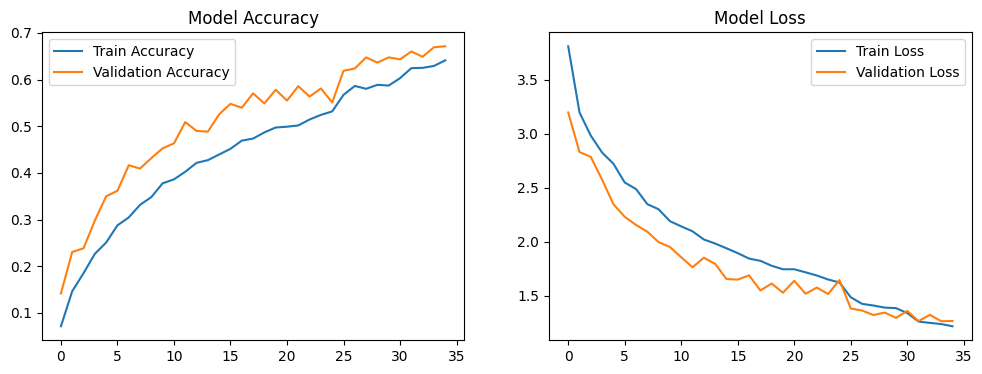

In [11]:
# Evaluasi pada test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

## **Penyetelan Hyperparameter**

In [ ]:
# Contoh penyetelan manual learning rate dan batch size
# Uji learning rate berbeda
learning_rates = [0.001, 0.0001, 0.00001]
batch_sizes = [16, 32, 64]

best_accuracy = 0
best_params = {}
num_classes = train_generator.num_classes

for lr in learning_rates:
    for bs in batch_sizes:
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            MaxPooling2D(2, 2),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(2, 2),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(optimizer=Adam(learning_rate=lr),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
        
        history = model.fit(
            train_generator,
            epochs=10,
            validation_data=val_generator,
            batch_size=bs,
            callbacks=[EarlyStopping(patience=3)],
            verbose=0
        )
        
        val_acc = max(history.history['val_accuracy'])
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_params = {'learning_rate': lr, 'batch_size': bs}

print(f"Best parameters: {best_params}, Best validation accuracy: {best_accuracy:.4f}")

## **Pengujian Model**

In [18]:
# Uji model dengan gambar baru
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    
    prediction = model.predict(img_array)
    class_names = list(train_generator.class_indices.keys())
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)
    return predicted_class, confidence

# Contoh penggunaan
img_path = 'test_model/image5.jpg'
predicted_class, confidence = predict_image(img_path)
print(f"Predicted class: {predicted_class}, Confidence: {confidence:.4f}")

1/1 [==============================] - 0s 127ms/step
Predicted class: Jamur, Confidence: 0.3460


## **Penggunaan Model**

In [20]:
# Simpan model
model.save('final_model1.h5')

# Muat model untuk penggunaan
loaded_model = load_model('final_model1.h5')

# Fungsi untuk prediksi berulang
def classify_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    
    prediction = model.predict(img_array)
    class_names = list(train_generator.class_indices.keys())
    predicted_class = class_names[np.argmax(prediction)]
    return predicted_class

# Contoh penggunaan
print(classify_image('test_model/image4.jpg', loaded_model))

1/1 [==============================] - 0s 126ms/step
Gula


In [27]:
# Simpan model ke format SavedModel
model.save('convert_saved_model/food_ingredients_model')
print("Model disimpan dengan format SavedModel!")

INFO:tensorflow:Assets written to: convert_saved_model/food_ingredients_model\assets


INFO:tensorflow:Assets written to: convert_saved_model/food_ingredients_model\assets


Model disimpan dengan format SavedModel!


In [29]:
# konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('convert_saved_model/food_ingredients_model')
tflite_model = converter.convert()

# menyimpan file TFLite
with open('convert_tflite/food_ingredients_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model dikonversi dan disimpan dengan format TF-Lite!")

Model dikonversi dan disimpan dengan format TF-Lite!


In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog

In [38]:

# Langkah 1: Baca class_names secara otomatis dari direktori dataset
# train_dir = 'path/to/train_dir'  # Ganti dengan direktori train Anda

# Buat generator sementara untuk membaca kelas
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Pastikan shuffle=False agar urutan kelas konsisten
)

# Ambil daftar kelas dari class_indices
class_names = list(train_generator.class_indices.keys())
print(f"Jumlah kelas: {len(class_names)}")
print(f"Daftar kelas: {class_names}")

Found 9742 images belonging to 75 classes.
Jumlah kelas: 75
Daftar kelas: ['Apel', 'Bawang Bombai', 'Bawang Merah', 'Bawang Putih', 'Belimbing', 'Brokoli', 'Buah Naga', 'Cabai Hijau', 'Cabai Merah', 'Cumi-cumi', 'Daging Sapi', 'Daging Unggas', 'Daun Salam', 'Garam', 'Gula', 'Gurita', 'Ikan', 'Jagung', 'Jahe', 'Jambu', 'Jamur', 'Jeroan', 'Jeruk', 'Kacang Hijau', 'Kacang Merah', 'Kacang Panjang', 'Kacang Tanah', 'Keju', 'Kembang Kol', 'Kencur', 'Kentang', 'Kikil', 'Kol', 'Kunyit', 'Kurma', 'Labu Siam', 'Leci', 'Lengkuas', 'Lobster', 'Manggis', 'Melon', 'Merica', 'Mie', 'Nanas', 'Nangka', 'Nasi', 'Oatmeal', 'Paprika', 'Pepaya', 'Petai', 'Pir', 'Pisang', 'Salak', 'Sawi', 'Sawo', 'Selada', 'Seledri', 'Semangka', 'Serai', 'Sirsak', 'Spaghetti', 'Stroberi', 'Susu', 'Telur Ayam', 'Telur Bebek', 'Tempe', 'Tepung Terigu', 'Terong', 'Timun', 'Tofu', 'Tomat', 'Ubi', 'Udang', 'Usus', 'Wortel']


Output shape: [ 1 75]


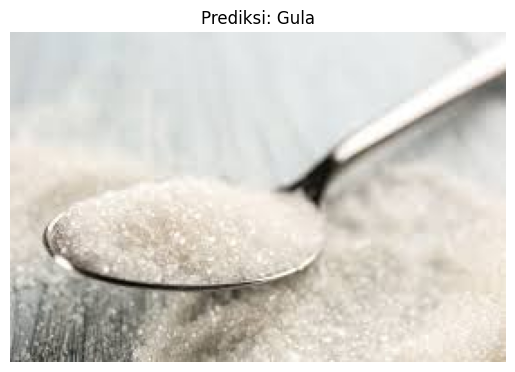


Prediksi Label: Gula


In [ ]:
# Langkah 2: Load model TFLite
interpreter = tf.lite.Interpreter(model_path='convert_tflite/food_ingredients_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Verifikasi output shape
# print("Output shape:", output_details[0]['shape'])  # Harus [1, 75]

# Langkah 3: Fungsi Preprocessing gambar
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img

# Langkah 4: Fungsi Inference
def predict_image(img_path):
    img = preprocess_image(img_path)
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    prediction = np.argmax(output_data, axis=1)[0]
    return prediction, output_data

# Langkah 5: Inisialisasi GUI untuk memilih file
root = Tk()
root.withdraw()  
img_path = filedialog.askopenfilename(title="Pilih gambar untuk diuji", filetypes=[("Image Files", "*.png;*.jpg;*.jpeg")])

if img_path:
    prediction, raw_output = predict_image(img_path)
   # print(f"Indeks prediksi: {prediction}")
   # print(f"Output probabilitas: {raw_output}")

    if prediction < len(class_names):
        # Tampilkan gambar dan hasil
        plt.imshow(image.load_img(img_path))
        plt.title(f"Prediksi: {class_names[prediction]}")
        plt.axis('off')
        plt.show()

        print(f"\nPrediksi Label: {class_names[prediction]}")
       # print(f"Output Probabilitas: {raw_output}")
    else:
        print(f"Error: Indeks prediksi ({prediction}) melebihi jumlah kelas ({len(class_names)}). Periksa class_names.")
else:
    print("Tidak ada file yang dipilih.")